In odrer to compare structured dropout and iid dropout in a linear model regime, we use the simulations embedded in sklearn (which make use of the Madelon synthetic dataset, see references in http://archive.ics.uci.edu/ml/datasets/madelon )
we vary: 
- the number of variables of redundant variables
- the number of overall variables 

we assess classification accuracy on a test set drawn from the same simulation



In [1]:
import sklearn
from sklearn.datasets import make_classification


import numpy as np
import tensorflow as tf
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

batch_size=32
dim=1000


/Users/beyrem/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from tensorflow.contrib.distributions import MultivariateNormalFullCovariance as mvnfc

def dropout_layer(x, mode, l,dim):

    if mode == 'add':
       #mu = tf.Variable(lambda : tf.ones(shape=[dim]))
        cov = tf.eye(dim, dtype='float32')
        sample = mvnfc(tf.zeros(shape=[dim]), cov).sample()
        return tf.math.add(x, np.sqrt(l)* sample)

    elif mode == 'mult':
      # mu = tf.Variable(lambda : tf.ones(shape=[dim]))
        cov =  tf.eye(dim, dtype='float32')
        sample = mvnfc(tf.zeros(shape=[dim]), cov).sample()
        return tf.multiply(x, np.sqrt(l)* sample + tf.ones(shape=[dim]))

    elif mode == 'drop':
      # mu = tf.Variable(lambda : tf.ones(shape=[dim]))

#         cov =  tf.eye(dim, dtype='float32')
        p_mat = tf.constant(1/(1+l), shape=(batch_size, dim))
        sample = tf.contrib.distributions.Bernoulli(probs=p_mat, dtype='float32').sample()
        return tf.multiply( (l+1)* x, sample )

    else:  # no noise 
        return x


class Linear_Model:

    def __init__(self, dim, nb_classes, batch_size, l, mode=None):
        
      #  p = l / (l + 1) # * tf.ones(shape=[batch_size, dim], dtype='float32')

        self.X = tf.placeholder(tf.float32, [None, dim])
        self.Y = tf.placeholder(tf.float32, [None, nb_classes])
        self.train = tf.placeholder(tf.bool)

        self.W = tf.Variable(tf.random_uniform([dim, nb_classes], -0.01, 0.01))  # model weights
        b = tf.Variable(tf.zeros(shape=[nb_classes]))                       # model biases

        x = tf.cond(self.train, lambda : dropout_layer(self.X, mode, l, dim), lambda : self.X)
        x = tf.cond(self.train, lambda : tf.matmul(x, self.W ) + b, lambda : tf.matmul(x, self.W ) + b)

        # Minimize error using cross entropy
        self.probs = tf.nn.sigmoid(x)
        log_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=x, labels=self.Y)
        self.mean_log_loss = tf.reduce_mean(log_loss)

The first simulation has 1000 features, with 100 informative features (nor redundant features), 1 cluster per class and flipping probability of 0.01

In [3]:
x_all, y_all= sklearn.datasets.make_classification(n_samples=10101, n_features=1000, n_informative=100, n_redundant=0, n_repeated=0, n_classes=1, n_clusters_per_class=2, weights=None, flip_y=0.01, class_sep=1.0, hypercube=True, shift=0.0, scale=1.0, shuffle=True, random_state=None)
x_train=x_all[range(100),]
y_train=y_all[range(100),]
x_test=x_all[101:,]
y_test=y_all[101:]


dim = 1000
nb_train = x_train.shape[0]
nb_test = x_test.shape[0]
nb_classes=1

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')


print('x_train shape:', x_train.shape)
print(nb_train, 'train samples')
print(nb_test, 'test samples')

# Convert class vectors to binary class matrices.
#y_train = to_categorical(y_train, nb_classes)
#y_test = to_categorical(y_test, nb_classes)

y_train=y_train.reshape(nb_train,1)
y_test=y_test.reshape(nb_test,1)

batch_size = 32  

('x_train shape:', (100, 1000))
(100, 'train samples')
(10000, 'test samples')


In [4]:
def training(seqlambda, mode, max_iters=6000, learning_rate=1):
    all_accuracies = []
    all_cor_norms = []
    acts1 = []
    for lamb in seqlambda:

        print('Lamb', lamb)
        accs = [] ; cor_norms = [] 
        
        model = Linear_Model(dim, nb_classes, batch_size, lamb, mode)
        #model = MLP(dimension, nb_hidden1, nb_hidden2,nb_classes, batch_size, lamb, mode)

        # training parameters
        optimiser = tf.train.AdamOptimizer().minimize(model.mean_log_loss)
        #optimiser = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(model.mean_log_loss)
        with tf.Session() as sess:

            sess.run(tf.global_variables_initializer())

            for iters in range(max_iters):

                idx = np.random.randint(nb_train, size=batch_size)

                _, loss,train_probs = sess.run([optimiser, model.mean_log_loss,model.probs], feed_dict={
                    model.X : x_train[idx], model.Y : y_train[idx], model.train : True})
                acc = np.sum(np.round(train_probs) == y_train[idx]) / float(128)
               # print("train_accuracy",acc)
                #print(np.sum(err1))
                #print(np.sum(err2))
            

                if iters % 200 == 0:
                    print('Iteration: %d, %.03f' % (iters, loss))  
                    pred,act1= sess.run([model.probs,model.W],
                                    feed_dict={model.X : x_test, model.train : False})
                 
                    acc = np.sum(np.round(pred) == y_test) / float(nb_test)
                    accs.append(acc)
                    print('Accuracy: %.03f' % acc)

            all_accuracies.append(accs)
            
        acts1.append(act1)
            
    return all_accuracies, acts1

max_iters = 2000
lambdas = [1e-2,1e-1,1e-0]

print('#### No dropout ####')
acc_linear,act1_linear= training([None], None, max_iters)

print('#### additive gaussian noise  ####')
acc_add, act1_add  = training(lambdas, 'add', max_iters)

print('#### multiplicative gaussian noise ####')
acc_mult,act1_mult = training(lambdas, 'mult', max_iters)

print('#### dropout ####')
acc_drop, act1_drop = training(lambdas, 'drop', max_iters)
   

#### No dropout ####
('Lamb', None)
Iteration: 0, 0.705
Accuracy: 0.463
Iteration: 200, 0.015
Accuracy: 0.794
Iteration: 400, 0.005
Accuracy: 0.797
Iteration: 600, 0.003
Accuracy: 0.797
Iteration: 800, 0.002
Accuracy: 0.798
Iteration: 1000, 0.001
Accuracy: 0.797
Iteration: 1200, 0.001
Accuracy: 0.797
Iteration: 1400, 0.001
Accuracy: 0.797
Iteration: 1600, 0.001
Accuracy: 0.797
Iteration: 1800, 0.000
Accuracy: 0.797
#### additive gaussian noise  ####
('Lamb', 0.01)
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow D

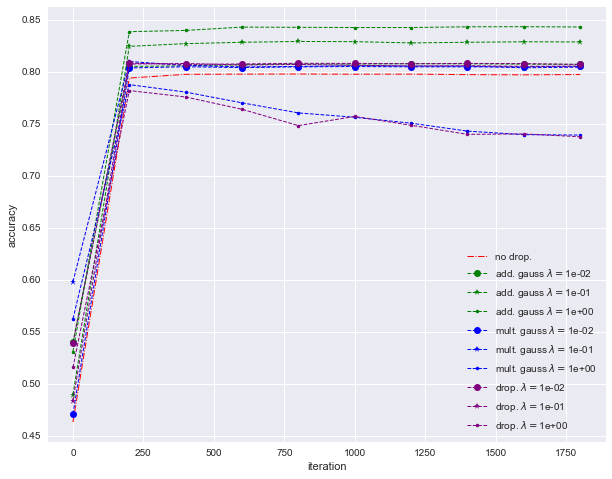

In [5]:
sns.set()

fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(np.arange(0, max_iters, 200), acc_linear[0], linestyle='-.',
        linewidth=1, color='red', label='no drop.')

line_styles = ['--o', '--*', '--.']

for i, series in enumerate(acc_add):
    ax.plot(np.arange(0, max_iters, 200), series,
            line_styles[i], color='green', linewidth=1,
            label=r'add. gauss $\lambda=$%.0e' % lambdas[i])

for i, series in enumerate(acc_mult):
    ax.plot(np.arange(0, max_iters, 200), series,
            line_styles[i], color='blue', linewidth=1,
            label=r'mult. gauss $\lambda=$%.0e' % lambdas[i])

    
for i, series in enumerate(acc_drop):
    ax.plot(np.arange(0, max_iters, 200), series,
            line_styles[i], color='purple', linewidth=1,
            label=r'drop. $\lambda=$%.0e' % lambdas[i])

    
ax.set_xlabel('iteration')
ax.set_ylabel('accuracy')

# ax.set_ylim([0.8, 1.0])

plt.legend()
plt.show()

Text(0.5,1,u'$\\lambda = 0E+00$ mean activations')

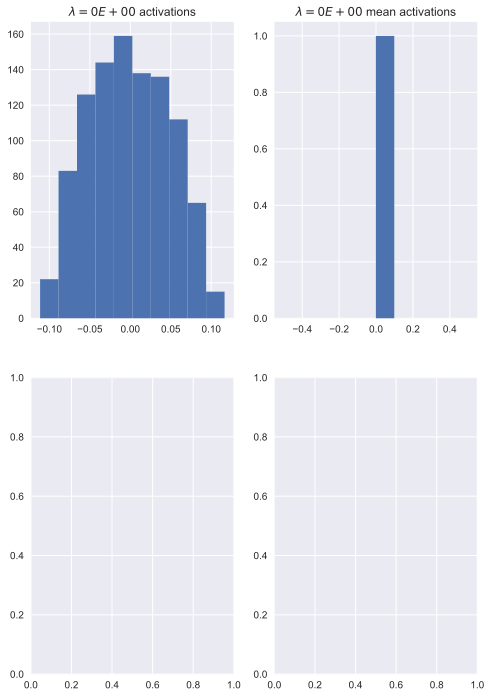

In [10]:
fig, axes = plt.subplots(figsize=(8, 12), ncols=2, nrows=2)
_ = axes[0][0].hist(act1_linear[0].flatten())
axes[0][0].set_title(r'$\lambda = %0.0E$ activations' % lambdas[0])
mean_activations = np.mean(act1_linear[0], axis=0)
_ = axes[0][1].hist(mean_activations)
axes[0][1].set_title(r'$\lambda = %0.0E$ mean activations' % lambdas[0])

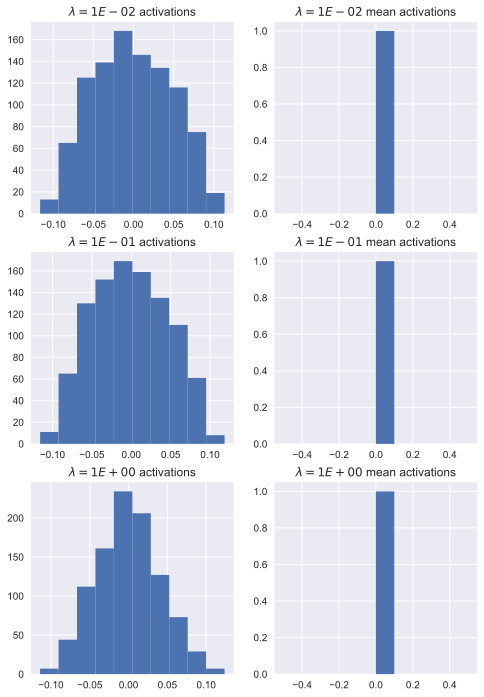

In [11]:
fig, axes = plt.subplots(figsize=(8, 12), ncols=2, nrows=3)
_ = axes[0][0].hist(act1_add[0].flatten())
axes[0][0].set_title(r'$\lambda = %0.0E$ activations' % lambdas[1])
mean_activations = np.mean(act1_add[0], axis=0)
_ = axes[0][1].hist(mean_activations)
axes[0][1].set_title(r'$\lambda = %0.0E$ mean activations' % lambdas[1])
_ = axes[1][0].hist(act1_add[1].flatten())
axes[1][0].set_title(r'$\lambda = %0.0E$ activations' % lambdas[2])
mean_activations = np.mean(act1_add[1], axis=0)
_ = axes[1][1].hist(mean_activations)
axes[1][1].set_title(r'$\lambda = %0.0E$ mean activations' % lambdas[2])
_ = axes[2][0].hist(act1_add[2].flatten())
axes[2][0].set_title(r'$\lambda = %0.0E$ activations' % lambdas[3])
mean_activations = np.mean(act1_add[2], axis=0)
_ = axes[2][1].hist(mean_activations)
axes[2][1].set_title(r'$\lambda = %0.0E$ mean activations' % lambdas[3])
plt.show()


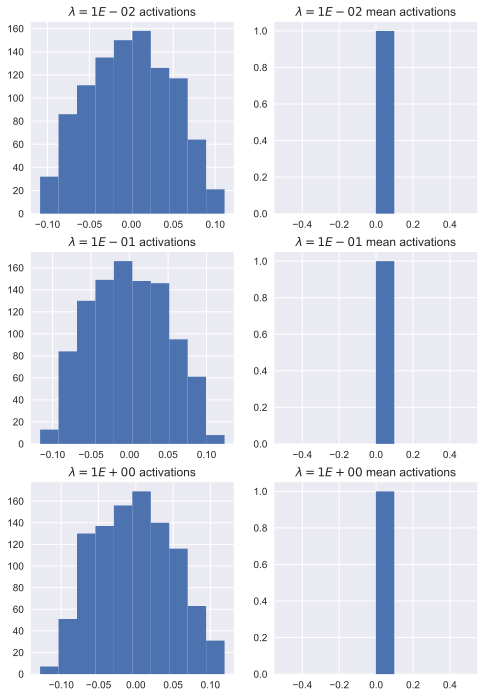

In [12]:
fig, axes = plt.subplots(figsize=(8, 12), ncols=2, nrows=3)
_ = axes[0][0].hist(act1_mult[0].flatten())
axes[0][0].set_title(r'$\lambda = %0.0E$ activations' % lambdas[1])
mean_activations = np.mean(act1_mult[1], axis=0)
_ = axes[0][1].hist(mean_activations)
axes[0][1].set_title(r'$\lambda = %0.0E$ mean activations' % lambdas[1])
_ = axes[1][0].hist(act1_mult[1].flatten())
axes[1][0].set_title(r'$\lambda = %0.0E$ activations' % lambdas[2])
mean_activations = np.mean(act1_mult[2], axis=0)
_ = axes[1][1].hist(mean_activations)
axes[1][1].set_title(r'$\lambda = %0.0E$ mean activations' % lambdas[2])
_ = axes[2][0].hist(act1_mult[2].flatten())
axes[2][0].set_title(r'$\lambda = %0.0E$ activations' % lambdas[3])
mean_activations = np.mean(act1_mult[3], axis=0)
_ = axes[2][1].hist(mean_activations)
axes[2][1].set_title(r'$\lambda = %0.0E$ mean activations' % lambdas[3])
plt.show()

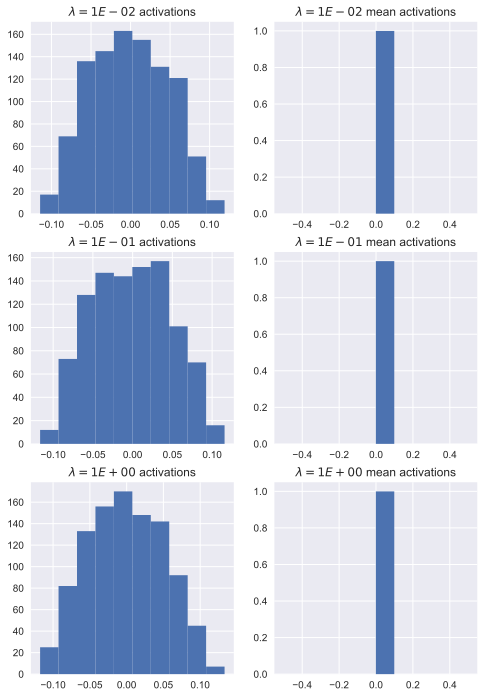

In [14]:
fig, axes = plt.subplots(figsize=(8, 12), ncols=2, nrows=3)
_ = axes[0][0].hist(act1_drop[0].flatten())
axes[0][0].set_title(r'$\lambda = %0.0E$ activations' % lambdas[1])
mean_activations = np.mean(act1_drop[0], axis=0)
_ = axes[0][1].hist(mean_activations)
axes[0][1].set_title(r'$\lambda = %0.0E$ mean activations' % lambdas[1])
_ = axes[1][0].hist(act1_drop[1].flatten())
axes[1][0].set_title(r'$\lambda = %0.0E$ activations' % lambdas[2])
mean_activations = np.mean(act1_drop[1], axis=0)
_ = axes[1][1].hist(mean_activations)
axes[1][1].set_title(r'$\lambda = %0.0E$ mean activations' % lambdas[2])
_ = axes[2][0].hist(act1_drop[2].flatten())
axes[2][0].set_title(r'$\lambda = %0.0E$ activations' % lambdas[3])
mean_activations = np.mean(act1_drop[2], axis=0)
_ = axes[2][1].hist(mean_activations)
axes[2][1].set_title(r'$\lambda = %0.0E$ mean activations' % lambdas[3])
plt.show()

In [15]:
np.max(acc_linear)

0.7613

In [18]:
[np.max(accs) for accs in acc_add]

[0.7569, 0.7719, 0.7784, 0.7961]

In [19]:
[np.max(accs) for accs in acc_mult]

[0.7573, 0.7721, 0.765, 0.7476]

In [20]:
[np.max(accs) for accs in acc_drop]

[0.7659, 0.7696, 0.7527, 0.755]

In [9]:
import sklearn
from sklearn.datasets import make_classification


import numpy as np
import tensorflow as tf
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')



x_all, y_all= sklearn.datasets.make_classification(n_samples=10101, n_features=1000, n_informative=100, n_redundant=400, n_repeated=0, n_classes=2, n_clusters_per_class=1, weights=None, flip_y=0.01, class_sep=1.0, hypercube=True, shift=0.0, scale=1.0, shuffle=True, random_state=None)
x_train=x_all[range(100),]
y_train=y_all[range(100),]
x_test=x_all[101:,]
y_test=y_all[101:]


dim = 1000
nb_train = x_train.shape[0]
nb_test = x_test.shape[0]
nb_classes=1

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')


print('x_train shape:', x_train.shape)
print(nb_train, 'train samples')
print(nb_test, 'test samples')

# Convert class vectors to binary class matrices.
#y_train = to_categorical(y_train, nb_classes)
#y_test = to_categorical(y_test, nb_classes)

y_train=y_train.reshape(nb_train,1)
y_test=y_test.reshape(nb_test,1)

batch_size = 32

('x_train shape:', (100, 1000))
(100, 'train samples')
(10000, 'test samples')


In [12]:
def training(seqlambda, mode, max_iters=6000, learning_rate=1):
    all_accuracies = []
    all_cor_norms = []
    acts1 = []
    for lamb in seqlambda:

        print('Lamb', lamb)
        accs = [] ; cor_norms = [] 
        
        model = Linear_Model(dim, nb_classes, batch_size, lamb, mode)
        #model = MLP(dimension, nb_hidden1, nb_hidden2,nb_classes, batch_size, lamb, mode)

        # training parameters
        optimiser = tf.train.AdamOptimizer().minimize(model.mean_log_loss)
        #optimiser = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(model.mean_log_loss)
        with tf.Session() as sess:

            sess.run(tf.global_variables_initializer())

            for iters in range(max_iters):

                idx = np.random.randint(nb_train, size=batch_size)

                _, loss,train_probs = sess.run([optimiser, model.mean_log_loss,model.probs], feed_dict={
                    model.X : x_train[idx], model.Y : y_train[idx], model.train : True})
                acc = np.sum(np.round(train_probs) == y_train[idx]) / float(128)
               # print("train_accuracy",acc)
                #print(np.sum(err1))
                #print(np.sum(err2))
            

                if iters % 200 == 0:
                    print('Iteration: %d, %.03f' % (iters, loss))  
                    pred,act1= sess.run([model.probs,model.W],
                                    feed_dict={model.X : x_test, model.train : False})
                 
                    acc = np.sum(np.round(pred) == y_test) / float(nb_test)
                    accs.append(acc)
                    print('Accuracy: %.03f' % acc)

            all_accuracies.append(accs)
            
        acts1.append(act1)
            
    return all_accuracies, acts1

max_iters = 2000
lambdas = [1e-2,1e-1,1e-0]

print('#### No dropout ####')
acc_linear,act1_linear= training([None], None, max_iters)

print('#### additive gaussian noise  ####')
acc_add, act1_add  = training(lambdas, 'add', max_iters)

print('#### multiplicative gaussian noise ####')
acc_mult,act1_mult = training(lambdas, 'mult', max_iters)

print('#### dropout ####')
acc_drop, act1_drop = training(lambdas, 'drop', max_iters)
   

#### No dropout ####
('Lamb', None)
Iteration: 0, 1.349
Accuracy: 0.610
Iteration: 200, 0.001
Accuracy: 0.788
Iteration: 400, 0.000
Accuracy: 0.792
Iteration: 600, 0.000
Accuracy: 0.792
Iteration: 800, 0.000
Accuracy: 0.792
Iteration: 1000, 0.000
Accuracy: 0.794
Iteration: 1200, 0.000
Accuracy: 0.792
Iteration: 1400, 0.000
Accuracy: 0.792
Iteration: 1600, 0.000
Accuracy: 0.791
Iteration: 1800, 0.000
Accuracy: 0.792
#### additive gaussian noise  ####
('Lamb', 0.01)
Iteration: 0, 1.147
Accuracy: 0.534
Iteration: 200, 0.000
Accuracy: 0.802
Iteration: 400, 0.000
Accuracy: 0.802
Iteration: 600, 0.000
Accuracy: 0.802
Iteration: 800, 0.000
Accuracy: 0.802
Iteration: 1000, 0.000
Accuracy: 0.802
Iteration: 1200, 0.000
Accuracy: 0.802
Iteration: 1400, 0.000
Accuracy: 0.803
Iteration: 1600, 0.000
Accuracy: 0.803
Iteration: 1800, 0.000
Accuracy: 0.803
('Lamb', 0.1)
Iteration: 0, 1.941
Accuracy: 0.592
Iteration: 200, 0.000
Accuracy: 0.783
Iteration: 400, 0.001
Accuracy: 0.782
Iteration: 600, 0.000


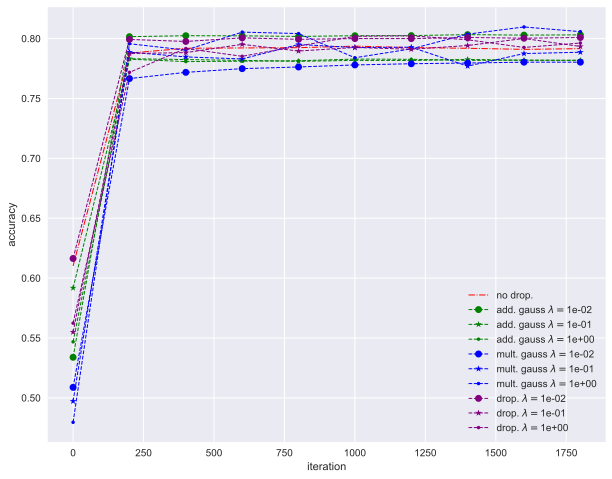

In [14]:
sns.set()

fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(np.arange(0, max_iters, 200), acc_linear[0], linestyle='-.',
        linewidth=1, color='red', label='no drop.')

line_styles = ['--o', '--*', '--.']

for i, series in enumerate(acc_add):
    ax.plot(np.arange(0, max_iters, 200), series,
            line_styles[i], color='green', linewidth=1,
            label=r'add. gauss $\lambda=$%.0e' % lambdas[i])

for i, series in enumerate(acc_mult):
    ax.plot(np.arange(0, max_iters, 200), series,
            line_styles[i], color='blue', linewidth=1,
            label=r'mult. gauss $\lambda=$%.0e' % lambdas[i])

    
for i, series in enumerate(acc_drop):
    ax.plot(np.arange(0, max_iters, 200), series,
            line_styles[i], color='purple', linewidth=1,
            label=r'drop. $\lambda=$%.0e' % lambdas[i])

    
ax.set_xlabel('iteration')
ax.set_ylabel('accuracy')

# ax.set_ylim([0.8, 1.0])

plt.legend()
plt.show()

In [16]:
[np.max(accs) for accs in acc_linear]

[0.7937]

In [17]:
[np.max(accs) for accs in acc_add]

[0.8033, 0.7832, 0.7829]

In [18]:
[np.max(accs) for accs in acc_mult]

[0.7803, 0.7951, 0.8097]

In [19]:
[np.max(accs) for accs in acc_drop]

[0.8009, 0.8001, 0.8023]

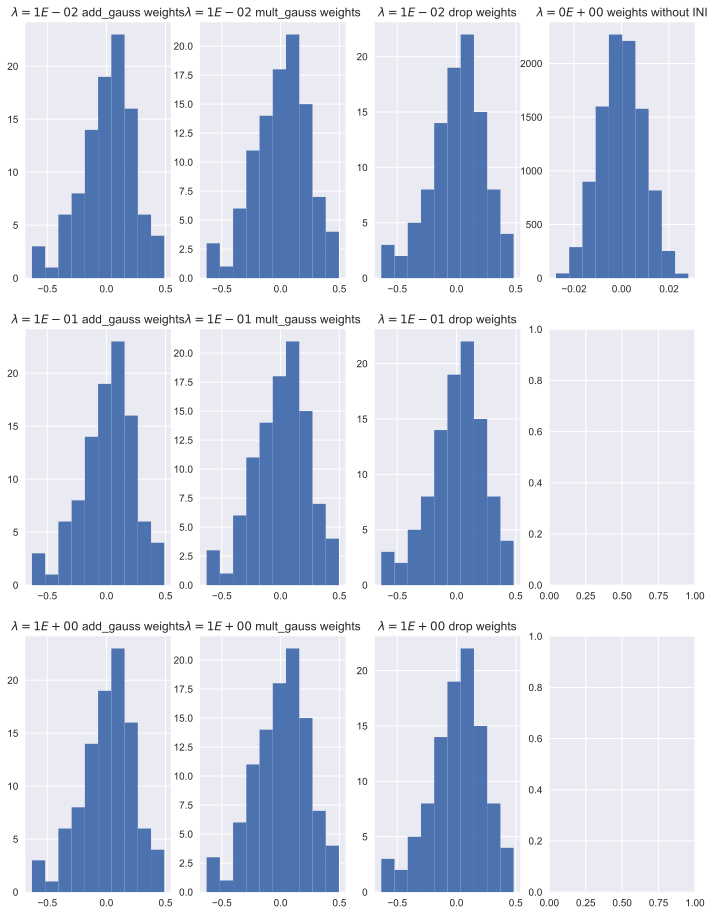

In [38]:
fig, axes = plt.subplots(figsize=(12, 16), ncols=4, nrows=3)

_ = axes[0][3].hist(act1_linear[0].flatten())
axes[0][3].set_title(r'$\lambda = %0.0E$ weights without INI' % lambdas[0])

_ = axes[0][0].hist(act1_add[1].flatten())
axes[0][0].set_title(r'$\lambda = %0.0E$ add_gauss weights' % lambdas[1])
_ = axes[0][1].hist(act1_mult[1].flatten())
axes[0][1].set_title(r'$\lambda = %0.0E$ mult_gauss weights' % lambdas[1])
_ = axes[0][2].hist(act1_drop[1].flatten())
axes[0][2].set_title(r'$\lambda = %0.0E$ drop weights' % lambdas[1])
_ = axes[1][0].hist(act1_add[1].flatten())
axes[1][0].set_title(r'$\lambda = %0.0E$ add_gauss weights' % lambdas[2])
_ = axes[1][1].hist(act1_mult[1].flatten())
axes[1][1].set_title(r'$\lambda = %0.0E$ mult_gauss weights' % lambdas[2])
_ = axes[1][2].hist(act1_drop[1].flatten())
axes[1][2].set_title(r'$\lambda = %0.0E$ drop weights' % lambdas[2])
_ = axes[2][0].hist(act1_add[1].flatten())
axes[2][0].set_title(r'$\lambda = %0.0E$ add_gauss weights' % lambdas[3])
_ = axes[2][1].hist(act1_mult[1].flatten())
axes[2][1].set_title(r'$\lambda = %0.0E$ mult_gauss weights' % lambdas[3])
_ = axes[2][2].hist(act1_drop[1].flatten())
axes[2][2].set_title(r'$\lambda = %0.0E$ drop weights' % lambdas[3])
plt.show()

We now vary the number of clusters, the more clusters per class we have, the harder the problem will be. Let's see if the effect of noise injection will also be beneficial and what noise injection method is better : 

In [15]:
import sklearn
from sklearn.datasets import make_classification


import numpy as np
import tensorflow as tf
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')



x_all, y_all= sklearn.datasets.make_classification(n_samples=10101, n_features=1000, n_informative=100, n_redundant=800, n_repeated=0, n_classes=2, n_clusters_per_class=1, weights=None, flip_y=0.01, class_sep=1.0, hypercube=True, shift=0.0, scale=1.0, shuffle=True, random_state=None)
x_train=x_all[range(100),]
y_train=y_all[range(100),]
x_test=x_all[101:,]
y_test=y_all[101:]


dim = 1000
nb_train = x_train.shape[0]
nb_test = x_test.shape[0]
nb_classes=1

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')


print('x_train shape:', x_train.shape)
print(nb_train, 'train samples')
print(nb_test, 'test samples')

# Convert class vectors to binary class matrices.
#y_train = to_categorical(y_train, nb_classes)
#y_test = to_categorical(y_test, nb_classes)

y_train=y_train.reshape(nb_train,1)
y_test=y_test.reshape(nb_test,1)

batch_size = 16

('x_train shape:', (100, 1000))
(100, 'train samples')
(10000, 'test samples')


In [21]:
def training(seqlambda, mode, max_iters=6000, learning_rate=1):
    all_accuracies = []
    all_cor_norms = []
    acts1 = []
    for lamb in seqlambda:

        print('Lamb', lamb)
        accs = [] ; cor_norms = [] 
        
        model = Linear_Model(dim, nb_classes, batch_size, lamb, mode)
        #model = MLP(dimension, nb_hidden1, nb_hidden2,nb_classes, batch_size, lamb, mode)

        # training parameters
        optimiser = tf.train.AdamOptimizer().minimize(model.mean_log_loss)
        #optimiser = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(model.mean_log_loss)
        with tf.Session() as sess:

            sess.run(tf.global_variables_initializer())

            for iters in range(max_iters):

                idx = np.random.randint(nb_train, size=batch_size)

                _, loss,train_probs = sess.run([optimiser, model.mean_log_loss,model.probs], feed_dict={
                    model.X : x_train[idx], model.Y : y_train[idx], model.train : True})
                acc = np.sum(np.round(train_probs) == y_train[idx]) / float(128)
               # print("train_accuracy",acc)
                #print(np.sum(err1))
                #print(np.sum(err2))
            

                if iters % 200 == 0:
                    print('Iteration: %d, %.03f' % (iters, loss))  
                    pred,act1= sess.run([model.probs,model.W],
                                    feed_dict={model.X : x_test, model.train : False})
                 
                    acc = np.sum(np.round(pred) == y_test) / float(nb_test)
                    accs.append(acc)
                    print('Accuracy: %.03f' % acc)

            all_accuracies.append(accs)
            
        acts1.append(act1)
            
    return all_accuracies, acts1

max_iters = 2000
lambdas = [1e-2,1e-1,1e-0]

print('#### No dropout ####')
acc_linear,act1_linear= training([None], None, max_iters)

print('#### additive gaussian noise  ####')
acc_add, act1_add  = training(lambdas, 'add', max_iters)

print('#### multiplicative gaussian noise ####')
acc_mult,act1_mult = training(lambdas, 'mult', max_iters)

print('#### dropout ####')
acc_drop, act1_drop = training(lambdas, 'drop', max_iters)
   

#### No dropout ####
('Lamb', None)
Iteration: 0, 2.328
Accuracy: 0.570
Iteration: 200, 0.000
Accuracy: 0.796
Iteration: 400, 0.000
Accuracy: 0.798
Iteration: 600, 0.000
Accuracy: 0.798
Iteration: 800, 0.000
Accuracy: 0.799
Iteration: 1000, 0.000
Accuracy: 0.799
Iteration: 1200, 0.000
Accuracy: 0.800
Iteration: 1400, 0.000
Accuracy: 0.800
Iteration: 1600, 0.000
Accuracy: 0.800
Iteration: 1800, 0.000
Accuracy: 0.800
#### additive gaussian noise  ####
('Lamb', 0.01)
Iteration: 0, 1.857
Accuracy: 0.569
Iteration: 200, 0.000
Accuracy: 0.781
Iteration: 400, 0.000
Accuracy: 0.782
Iteration: 600, 0.000
Accuracy: 0.784
Iteration: 800, 0.000
Accuracy: 0.784
Iteration: 1000, 0.000
Accuracy: 0.785
Iteration: 1200, 0.000
Accuracy: 0.786
Iteration: 1400, 0.000
Accuracy: 0.787
Iteration: 1600, 0.000
Accuracy: 0.787
Iteration: 1800, 0.000
Accuracy: 0.787
('Lamb', 0.1)
Iteration: 0, 3.225
Accuracy: 0.592
Iteration: 200, 0.000
Accuracy: 0.758
Iteration: 400, 0.000
Accuracy: 0.762
Iteration: 600, 0.000


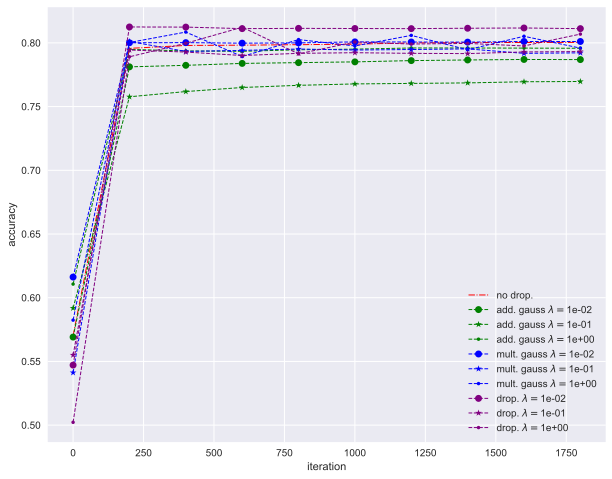

In [22]:
sns.set()

fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(np.arange(0, max_iters, 200), acc_linear[0], linestyle='-.',
        linewidth=1, color='red', label='no drop.')

line_styles = ['--o', '--*', '--.']

for i, series in enumerate(acc_add):
    ax.plot(np.arange(0, max_iters, 200), series,
            line_styles[i], color='green', linewidth=1,
            label=r'add. gauss $\lambda=$%.0e' % lambdas[i])

for i, series in enumerate(acc_mult):
    ax.plot(np.arange(0, max_iters, 200), series,
            line_styles[i], color='blue', linewidth=1,
            label=r'mult. gauss $\lambda=$%.0e' % lambdas[i])

    
for i, series in enumerate(acc_drop):
    ax.plot(np.arange(0, max_iters, 200), series,
            line_styles[i], color='purple', linewidth=1,
            label=r'drop. $\lambda=$%.0e' % lambdas[i])

    
ax.set_xlabel('iteration')
ax.set_ylabel('accuracy')

# ax.set_ylim([0.8, 1.0])

plt.legend()
plt.show()

In [23]:
[np.max(accs) for accs in acc_linear]

[0.8004]

In [24]:
[np.max(accs) for accs in acc_add]

[0.787, 0.7697, 0.796]

In [25]:
[np.max(accs) for accs in acc_mult]

[0.8011, 0.8011, 0.8085]

In [26]:
[np.max(accs) for accs in acc_drop]

[0.8125, 0.7944, 0.8123]

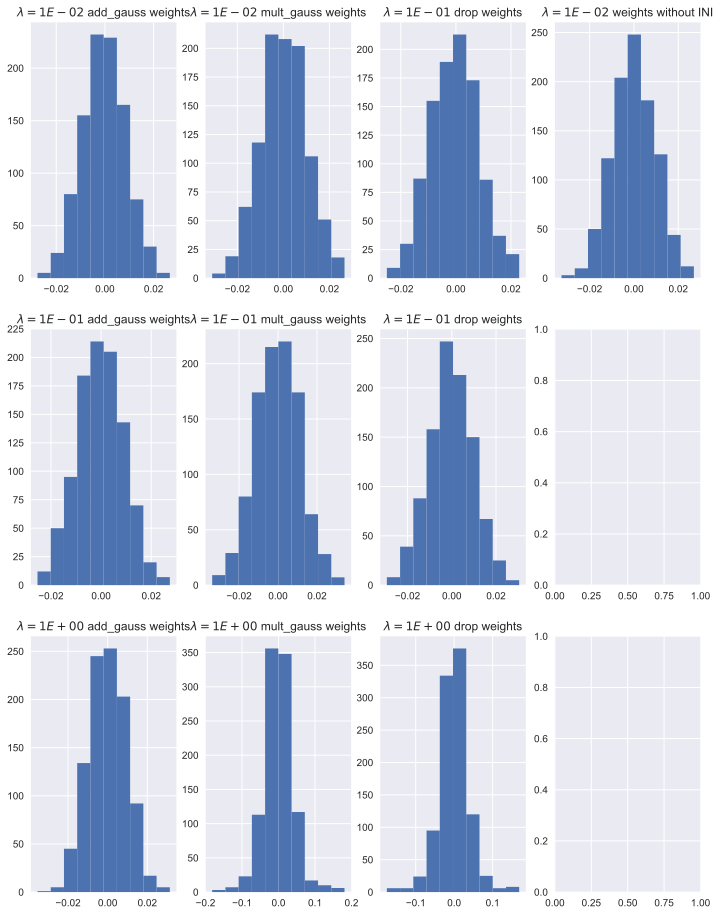

In [27]:
fig, axes = plt.subplots(figsize=(12, 16), ncols=4, nrows=3)

_ = axes[0][3].hist(act1_linear[0].flatten())
axes[0][3].set_title(r'$\lambda = %0.0E$ weights without INI' % lambdas[0])

_ = axes[0][0].hist(act1_add[0].flatten())
axes[0][0].set_title(r'$\lambda = %0.0E$ add_gauss weights' % lambdas[0])
_ = axes[0][1].hist(act1_mult[0].flatten())
axes[0][1].set_title(r'$\lambda = %0.0E$ mult_gauss weights' % lambdas[0])
_ = axes[0][2].hist(act1_drop[0].flatten())
axes[0][2].set_title(r'$\lambda = %0.0E$ drop weights' % lambdas[1])
_ = axes[1][0].hist(act1_add[1].flatten())
axes[1][0].set_title(r'$\lambda = %0.0E$ add_gauss weights' % lambdas[1])
_ = axes[1][1].hist(act1_mult[1].flatten())
axes[1][1].set_title(r'$\lambda = %0.0E$ mult_gauss weights' % lambdas[1])
_ = axes[1][2].hist(act1_drop[1].flatten())
axes[1][2].set_title(r'$\lambda = %0.0E$ drop weights' % lambdas[1])
_ = axes[2][0].hist(act1_add[2].flatten())
axes[2][0].set_title(r'$\lambda = %0.0E$ add_gauss weights' % lambdas[2])
_ = axes[2][1].hist(act1_mult[2].flatten())
axes[2][1].set_title(r'$\lambda = %0.0E$ mult_gauss weights' % lambdas[2])
_ = axes[2][2].hist(act1_drop[2].flatten())
axes[2][2].set_title(r'$\lambda = %0.0E$ drop weights' % lambdas[2])
plt.show()

In [33]:
sum(act1_drop[2]==0)

array([0])

In [54]:
import sklearn
from sklearn.datasets import make_classification


import numpy as np
import tensorflow as tf
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')



x_all, y_all= sklearn.datasets.make_classification(n_samples=10101, n_features=1000, n_informative=100, n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=5, weights=None, flip_y=0.01, class_sep=1.0, hypercube=True, shift=0.0, scale=1.0, shuffle=True, random_state=None)
x_train=x_all[range(100),]
y_train=y_all[range(100),]
x_test=x_all[101:,]
y_test=y_all[101:]


dim = 1000
nb_train = x_train.shape[0]
nb_test = x_test.shape[0]
nb_classes=1

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')


print('x_train shape:', x_train.shape)
print(nb_train, 'train samples')
print(nb_test, 'test samples')

# Convert class vectors to binary class matrices.
#y_train = to_categorical(y_train, nb_classes)
#y_test = to_categorical(y_test, nb_classes)

y_train=y_train.reshape(nb_train,1)
y_test=y_test.reshape(nb_test,1)

batch_size = 16

('x_train shape:', (100, 1000))
(100, 'train samples')
(10000, 'test samples')


In [55]:
def training(seqlambda, mode, max_iters=6000, learning_rate=1):
    all_accuracies = []
    all_cor_norms = []
    acts1 = []
    for lamb in seqlambda:

        print('Lamb', lamb)
        accs = [] ; cor_norms = [] 
        
        model = Linear_Model(dim, nb_classes, batch_size, lamb, mode)
        #model = MLP(dimension, nb_hidden1, nb_hidden2,nb_classes, batch_size, lamb, mode)

        # training parameters
        optimiser = tf.train.AdamOptimizer().minimize(model.mean_log_loss)
        #optimiser = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(model.mean_log_loss)
        with tf.Session() as sess:

            sess.run(tf.global_variables_initializer())

            for iters in range(max_iters):

                idx = np.random.randint(nb_train, size=batch_size)

                _, loss,train_probs = sess.run([optimiser, model.mean_log_loss,model.probs], feed_dict={
                    model.X : x_train[idx], model.Y : y_train[idx], model.train : True})
                acc = np.sum(np.round(train_probs) == y_train[idx]) / float(128)
               # print("train_accuracy",acc)
                #print(np.sum(err1))
                #print(np.sum(err2))
            

                if iters % 200 == 0:
                    print('Iteration: %d, %.03f' % (iters, loss))  
                    pred,act1= sess.run([model.probs,model.W],
                                    feed_dict={model.X : x_test, model.train : False})
                 
                    acc = np.sum(np.round(pred) == y_test) / float(nb_test)
                    accs.append(acc)
                    print('Accuracy: %.03f' % acc)

            all_accuracies.append(accs)
            
        acts1.append(act1)
            
    return all_accuracies, acts1

max_iters = 2000
lambdas = [0,1e-2,1e-1,1e-0]

print('#### No dropout ####')
acc_linear,act1_linear= training([None], None, max_iters)

print('#### additive gaussian noise  ####')
acc_add, act1_add  = training(lambdas, 'add', max_iters)

print('#### multiplicative gaussian noise ####')
acc_mult,act1_mult = training(lambdas, 'mult', max_iters)

print('#### dropout ####')
acc_drop, act1_drop = training(lambdas, 'drop', max_iters)
   

#### No dropout ####
('Lamb', None)
Iteration: 0, 0.703
Accuracy: 0.511
Iteration: 200, 0.021
Accuracy: 0.597
Iteration: 400, 0.006
Accuracy: 0.595
Iteration: 600, 0.004
Accuracy: 0.595
Iteration: 800, 0.003
Accuracy: 0.596
Iteration: 1000, 0.002
Accuracy: 0.596
Iteration: 1200, 0.001
Accuracy: 0.596
Iteration: 1400, 0.001
Accuracy: 0.596
Iteration: 1600, 0.001
Accuracy: 0.595
Iteration: 1800, 0.001
Accuracy: 0.596
#### additive gaussian noise  ####
('Lamb', 0.0)
Iteration: 0, 0.741
Accuracy: 0.536
Iteration: 200, 0.022
Accuracy: 0.598
Iteration: 400, 0.008
Accuracy: 0.600
Iteration: 600, 0.004
Accuracy: 0.600
Iteration: 800, 0.003
Accuracy: 0.599
Iteration: 1000, 0.002
Accuracy: 0.598
Iteration: 1200, 0.001
Accuracy: 0.597
Iteration: 1400, 0.001
Accuracy: 0.596
Iteration: 1600, 0.001
Accuracy: 0.596
Iteration: 1800, 0.001
Accuracy: 0.595
('Lamb', 0.01)
Iteration: 0, 0.673
Accuracy: 0.510
Iteration: 200, 0.021
Accuracy: 0.597
Iteration: 400, 0.009
Accuracy: 0.596
Iteration: 600, 0.005


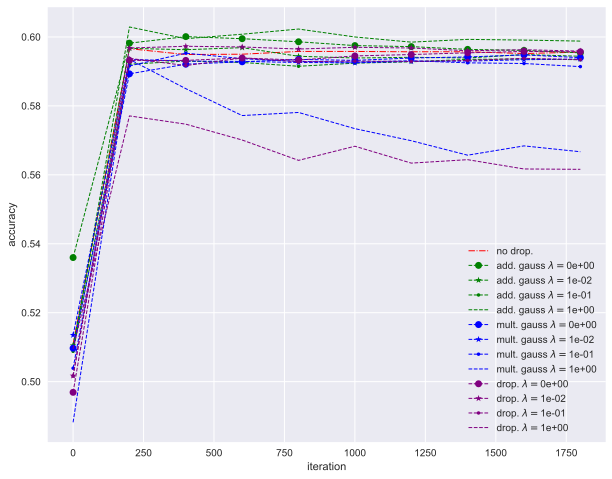

In [56]:
sns.set()

fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(np.arange(0, max_iters, 200), acc_linear[0], linestyle='-.',
        linewidth=1, color='red', label='no drop.')

line_styles = ['--o', '--*', '--.','--+']

for i, series in enumerate(acc_add):
    ax.plot(np.arange(0, max_iters, 200), series,
            line_styles[i], color='green', linewidth=1,
            label=r'add. gauss $\lambda=$%.0e' % lambdas[i])

for i, series in enumerate(acc_mult):
    ax.plot(np.arange(0, max_iters, 200), series,
            line_styles[i], color='blue', linewidth=1,
            label=r'mult. gauss $\lambda=$%.0e' % lambdas[i])

    
for i, series in enumerate(acc_drop):
    ax.plot(np.arange(0, max_iters, 200), series,
            line_styles[i], color='purple', linewidth=1,
            label=r'drop. $\lambda=$%.0e' % lambdas[i])

    
ax.set_xlabel('iteration')
ax.set_ylabel('accuracy')

# ax.set_ylim([0.8, 1.0])

plt.legend()
plt.show()

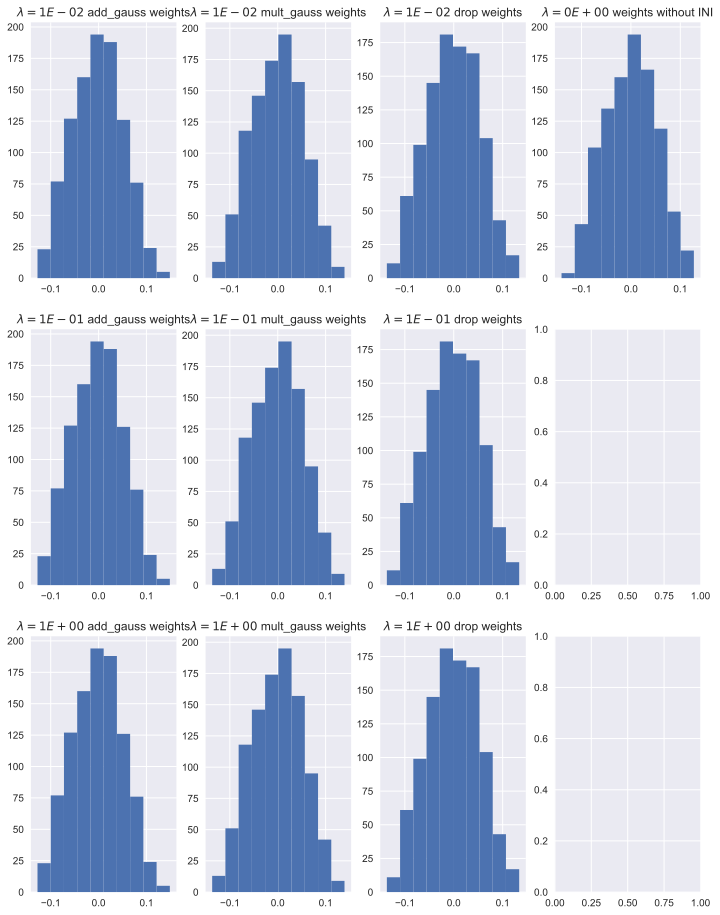

In [57]:
fig, axes = plt.subplots(figsize=(12, 16), ncols=4, nrows=3)

_ = axes[0][3].hist(act1_linear[0].flatten())
axes[0][3].set_title(r'$\lambda = %0.0E$ weights without INI' % lambdas[0])

_ = axes[0][0].hist(act1_add[1].flatten())
axes[0][0].set_title(r'$\lambda = %0.0E$ add_gauss weights' % lambdas[1])
_ = axes[0][1].hist(act1_mult[1].flatten())
axes[0][1].set_title(r'$\lambda = %0.0E$ mult_gauss weights' % lambdas[1])
_ = axes[0][2].hist(act1_drop[1].flatten())
axes[0][2].set_title(r'$\lambda = %0.0E$ drop weights' % lambdas[1])
_ = axes[1][0].hist(act1_add[1].flatten())
axes[1][0].set_title(r'$\lambda = %0.0E$ add_gauss weights' % lambdas[2])
_ = axes[1][1].hist(act1_mult[1].flatten())
axes[1][1].set_title(r'$\lambda = %0.0E$ mult_gauss weights' % lambdas[2])
_ = axes[1][2].hist(act1_drop[1].flatten())
axes[1][2].set_title(r'$\lambda = %0.0E$ drop weights' % lambdas[2])
_ = axes[2][0].hist(act1_add[1].flatten())
axes[2][0].set_title(r'$\lambda = %0.0E$ add_gauss weights' % lambdas[3])
_ = axes[2][1].hist(act1_mult[1].flatten())
axes[2][1].set_title(r'$\lambda = %0.0E$ mult_gauss weights' % lambdas[3])
_ = axes[2][2].hist(act1_drop[1].flatten())
axes[2][2].set_title(r'$\lambda = %0.0E$ drop weights' % lambdas[3])
plt.show()

In [24]:
import sklearn
from sklearn.datasets import make_classification


import numpy as np
import tensorflow as tf
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')


def generate_data(nb, dimension, Sigma,p_noise,w):
    x= np.random.poisson(lam=1,size=(nb,dim))
    #x= np.random.multivariate_normal(mean=np.zeros(dimension),cov=Sigma)
    pr= 1/(1+np.exp(-np.matmul(x,w)))
    pr
    y=np.random.binomial(1,pr,size=nb)
    bern=np.random.binomial(1,p_noise,size=(nb,dimension))
    x=np.multiply(x,bern)
    return  x,y,pr


dim=10000
Sigma= np.diag(np.ones(dim))
#size=10
nb_train=100
nb_test=100*nb_train
#w=np.multiply(0.00001 ,range(1000))
w=0.0001* np.ones(dim)
p_noise=1
    
    
x_train,y_train,pr= generate_data(nb_train, dim, Sigma,p_noise,w)
x_test,y_test,pr_test= generate_data(nb_test, dim, Sigma,p_noise,w)

nb_classes=1
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

y_train=y_train.reshape(nb_train,1)
y_test=y_test.reshape(nb_test,1)

batch_size=32


In [25]:
print(y_test)

[[0]
 [1]
 [0]
 ...
 [1]
 [1]
 [1]]


In [26]:
from tensorflow.contrib.distributions import MultivariateNormalFullCovariance as mvnfc

def dropout_layer(x, mode, l,dim):

    if mode == 'add':
       #mu = tf.Variable(lambda : tf.ones(shape=[dim]))
        cov = tf.eye(dim, dtype='float32')
        sample = mvnfc(tf.zeros(shape=[dim]), cov).sample()
        return tf.math.add(x, np.sqrt(l)* sample)

    elif mode == 'mult':
      # mu = tf.Variable(lambda : tf.ones(shape=[dim]))
        cov =  tf.eye(dim, dtype='float32')
        sample = mvnfc(tf.zeros(shape=[dim]), cov).sample()
        return tf.multiply(x, np.sqrt(l)* sample + tf.ones(shape=[dim]))

    elif mode == 'drop':
      # mu = tf.Variable(lambda : tf.ones(shape=[dim]))

#         cov =  tf.eye(dim, dtype='float32')
        p_mat = tf.constant(1/(1+l), shape=(batch_size, dim))
        sample = tf.contrib.distributions.Bernoulli(probs=p_mat, dtype='float32').sample()
        return tf.multiply( (l+1)* x, sample )

    else:  # no noise 
        return x


class Linear_Model:

    def __init__(self, dim, nb_classes, batch_size, l, mode=None):
        
      #  p = l / (l + 1) # * tf.ones(shape=[batch_size, dim], dtype='float32')

        self.X = tf.placeholder(tf.float32, [None, dim])
        self.Y = tf.placeholder(tf.float32, [None, nb_classes])
        self.train = tf.placeholder(tf.bool)

        self.W = tf.Variable(tf.random_uniform([dim, nb_classes], -0.01, 0.01))  # model weights
        b = tf.Variable(tf.zeros(shape=[nb_classes]))                       # model biases

        x = tf.cond(self.train, lambda : dropout_layer(self.X, mode, l, dim), lambda : self.X)
        x = tf.cond(self.train, lambda : tf.matmul(x, self.W ) + b, lambda : tf.matmul(x, self.W ) + b)

        # Minimize error using cross entropy
        self.probs = tf.nn.sigmoid(x)
        log_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=x, labels=self.Y)
        self.mean_log_loss = tf.reduce_mean(log_loss)

In [27]:
def training(seqlambda, mode, max_iters=6000, learning_rate=1):
    all_accuracies = []
    all_cor_norms = []
    acts1 = []
    for lamb in seqlambda:

        print('Lamb', lamb)
        accs = [] ; cor_norms = [] 
        
        model = Linear_Model(dim, nb_classes, batch_size, lamb, mode)
        #model = MLP(dimension, nb_hidden1, nb_hidden2,nb_classes, batch_size, lamb, mode)

        # training parameters
        #optimiser = tf.train.AdamOptimizer().minimize(model.mean_log_loss)
        optimiser = tf.train.GradientDescentOptimizer(learning_rate=0.001).minimize(model.mean_log_loss)
        with tf.Session() as sess:

            sess.run(tf.global_variables_initializer())

            for iters in range(max_iters):

                idx = np.random.randint(nb_train, size=batch_size)

                _, loss,train_probs = sess.run([optimiser, model.mean_log_loss,model.probs], feed_dict={
                    model.X : x_train[idx], model.Y : y_train[idx], model.train : True})
                acc = np.sum(np.round(train_probs) == y_train[idx]) / float(128)
               # print("train_accuracy",acc)
                #print(np.sum(err1))
                #print(np.sum(err2))
            

                if iters % 200 == 0:
                    print('Iteration: %d, %.03f' % (iters, loss))  
                    pred,act1= sess.run([model.probs,model.W],
                                    feed_dict={model.X : x_test, model.train : False})
                 
                    acc = np.sum(np.round(pred) == y_test) / float(nb_test)
                    accs.append(acc)
                    print('Accuracy: %.03f' % acc)

            all_accuracies.append(accs)
            
        acts1.append(act1)
            
    return all_accuracies, acts1

max_iters = 4000
lambdas = [0.,1e-2,1e-1,1e-0]

print('#### No dropout ####')
acc_linear,act1_linear= training([None], None, max_iters)

print('#### additive gaussian noise  ####')
#acc_add, act1_add  = training(lambdas, 'add', max_iters)

print('#### multiplicative gaussian noise ####')
#acc_mult,act1_mult = training(lambdas, 'mult', max_iters)

print('#### dropout ####')
acc_drop, act1_drop = training(lambdas, 'drop', max_iters)
   

#### No dropout ####
('Lamb', None)
Iteration: 0, 0.579
Accuracy: 0.726
Iteration: 200, 0.032
Accuracy: 0.725
Iteration: 400, 0.020
Accuracy: 0.726
Iteration: 600, 0.014
Accuracy: 0.726
Iteration: 800, 0.011
Accuracy: 0.726
Iteration: 1000, 0.007
Accuracy: 0.726
Iteration: 1200, 0.006
Accuracy: 0.726
Iteration: 1400, 0.006
Accuracy: 0.726
Iteration: 1600, 0.004
Accuracy: 0.726
Iteration: 1800, 0.003
Accuracy: 0.726
Iteration: 2000, 0.004
Accuracy: 0.726
Iteration: 2200, 0.004
Accuracy: 0.726
Iteration: 2400, 0.003
Accuracy: 0.726
Iteration: 2600, 0.003
Accuracy: 0.726
Iteration: 2800, 0.003
Accuracy: 0.726
Iteration: 3000, 0.003
Accuracy: 0.726
Iteration: 3200, 0.002
Accuracy: 0.726
Iteration: 3400, 0.002
Accuracy: 0.726
Iteration: 3600, 0.002
Accuracy: 0.726
Iteration: 3800, 0.002
Accuracy: 0.726
#### additive gaussian noise  ####
#### multiplicative gaussian noise ####
#### dropout ####
('Lamb', 0.0)
Iteration: 0, 1.157
Accuracy: 0.726
Iteration: 200, 0.036
Accuracy: 0.726
Iteration:

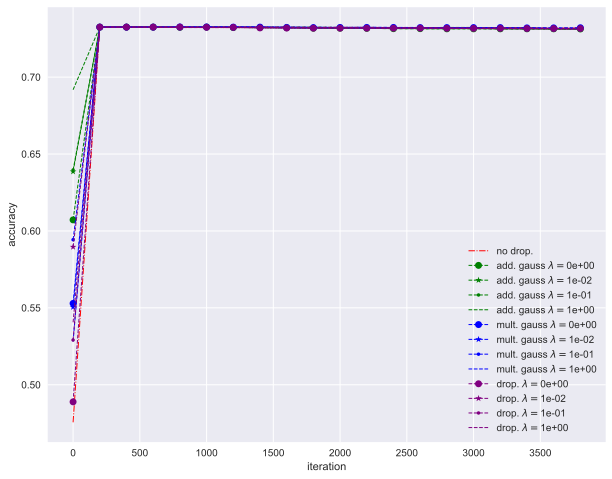

In [18]:
sns.set()

fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(np.arange(0, max_iters, 200), acc_linear[0], linestyle='-.',
        linewidth=1, color='red', label='no drop.')

line_styles = ['--o', '--*', '--.','--+']

for i, series in enumerate(acc_add):
    ax.plot(np.arange(0, max_iters, 200), series,
            line_styles[i], color='green', linewidth=1,
            label=r'add. gauss $\lambda=$%.0e' % lambdas[i])

for i, series in enumerate(acc_mult):
    ax.plot(np.arange(0, max_iters, 200), series,
            line_styles[i], color='blue', linewidth=1,
            label=r'mult. gauss $\lambda=$%.0e' % lambdas[i])

    
for i, series in enumerate(acc_drop):
    ax.plot(np.arange(0, max_iters, 200), series,
            line_styles[i], color='purple', linewidth=1,
            label=r'drop. $\lambda=$%.0e' % lambdas[i])

    
ax.set_xlabel('iteration')
ax.set_ylabel('accuracy')

# ax.set_ylim([0.8, 1.0])

plt.legend()
plt.show()

In [ ]:
sns.set()

fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(np.arange(0, max_iters, 200), cor_norms_linear[0], linestyle='-.',
        linewidth=1, color='red', label='no drop.')

line_styles = ['--^','--o', '--*','--.']

for i, series in enumerate(cor_norms_struc):
    ax.plot(np.arange(0, max_iters, 200), series,
            line_styles[i], color='blue', linewidth=1,
            label=r'struc. drop. $\lambda=$%.0e' % lambdas[i])

for i, series in enumerate(cor_norms_iid):
    ax.plot(np.arange(0, max_iters, 200), series,
            line_styles[i], color='green', linewidth=1,
            label=r'iid drop. $\lambda=$%.0e' % lambdas[i])

ax.set_xlabel('iteration')
ax.set_ylabel('$|\cdot|_F$')

# ax.set_ylim([0.8, 1.0])

plt.legend()
plt.show()

In [76]:
def training(seqlambda, mode, max_iters=6000, learning_rate=1):

    all_accuracies = []
    all_cor_norms = []
    acts1 = []
    for lamb in seqlambda:

        print('Lamb', lamb)
        accs = [] ; cor_norms = [] 
        
        model = Linear_Model(dim, nb_classes, batch_size, lamb, mode)
        #model = MLP(dimension, nb_hidden1, nb_hidden2,nb_classes, batch_size, lamb, mode)

        # training parameters
        optimiser = tf.train.AdamOptimizer().minimize(model.mean_log_loss)
        #optimiser = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(model.mean_log_loss)
        with tf.Session() as sess:

            sess.run(tf.global_variables_initializer())

            for iters in range(max_iters):

                idx = np.random.randint(nb_train, size=batch_size)

                _, loss,train_probs = sess.run([optimiser, model.mean_log_loss,model.probs], feed_dict={
                    model.X : x_train[idx], model.Y : y_train[idx], model.train : True})
                acc = np.sum(np.round(train_probs) == y_train[idx]) / float(128)
               # print("train_accuracy",acc)
                #print(np.sum(err1))
                #print(np.sum(err2))
            

                if iters % 200 == 0:
                    print('Iteration: %d, %.03f' % (iters, loss))  
                    pred= sess.run([model.probs],
                                    feed_dict={model.X : x_test, model.train : False})
                 
                    acc = np.sum(np.round(pred) == y_test) / float(nb_test)
                    accs.append(acc)
                    print('Accuracy: %.03f' % acc)
            
            all_accuracies.append(accs)


    return all_accuracies


max_iters = 600
lambdas = [1e-2,1e-1]



acc_linear=[]
acc_add=[]
acc_mult=[]
acc_drop=[]

for i in range(2):            
    x_all, y_all= sklearn.datasets.make_classification(n_samples=10101, n_features=100, n_informative=10, n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=1, weights=None, flip_y=0.01, class_sep=1.0, hypercube=True, shift=0.0, scale=1.0, shuffle=True, random_state=None)
    x_train=x_all[range(100),]
    y_train=y_all[range(100),]
    x_test=x_all[101:,]
    y_test=y_all[101:]


    dim = 100 
    nb_train = x_train.shape[0]
    nb_test = x_test.shape[0]
    nb_classes=1

    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')


    print('x_train shape:', x_train.shape)
    print(nb_train, 'train samples')
    print(nb_test, 'test samples')

    # Convert class vectors to binary class matrices.
    #y_train = to_categorical(y_train, nb_classes)
    #y_test = to_categorical(y_test, nb_classes)

    y_train=y_train.reshape(nb_train,1)
    y_test=y_test.reshape(nb_test,1)

    batch_size = 32

    print('#### No dropout #### iteration ',i)
    acc_add_i=training(lambdas, 'add', max_iters)
    acc_add.append([accs[-1] for accs in acc_add_i])
    print('#### additive gaussian noise  #### iteration ',i)
    acc_mult_i=training(lambdas, 'mult', max_iters)
    acc_mult.append([accs[-1] for accs in acc_mult_i])

    print('#### multiplicative gaussian noise #### iteration ',i)
    acc_drop_i=training(lambdas, 'drop', max_iters)
    acc_drop.append([accs[-1] for accs in acc_drop_i])
    print('#### dropout ####   iteration ',i)
    acc_drop_i=training(lambdas, 'drop', max_iters)
    acc_drop.append([accs[-1] for accs in acc_drop_i])

('x_train shape:', (100, 100))
(100, 'train samples')
(10000, 'test samples')
('#### No dropout #### iteration ', 0)
('#### additive gaussian noise  #### iteration ', 0)
('#### multiplicative gaussian noise #### iteration ', 0)
('#### dropout ####   iteration ', 0)
('Lamb', 0.01)
Iteration: 0, 0.695
Accuracy: 0.476
Iteration: 200, 0.226
Accuracy: 0.878
Iteration: 400, 0.140
Accuracy: 0.884
('Lamb', 0.1)
Iteration: 0, 0.695
Accuracy: 0.556
Iteration: 200, 0.253
Accuracy: 0.876
Iteration: 400, 0.132
Accuracy: 0.887
('x_train shape:', (100, 100))
(100, 'train samples')
(10000, 'test samples')
('#### No dropout #### iteration ', 1)
('#### additive gaussian noise  #### iteration ', 1)
('#### multiplicative gaussian noise #### iteration ', 1)
('#### dropout ####   iteration ', 1)
('Lamb', 0.01)
Iteration: 0, 0.699
Accuracy: 0.469
Iteration: 200, 0.395
Accuracy: 0.711
Iteration: 400, 0.277
Accuracy: 0.728
('Lamb', 0.1)
Iteration: 0, 0.692
Accuracy: 0.560
Iteration: 200, 0.311
Accuracy: 0.720


In [85]:
sns.set()

fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(np.arange(0, max_iters, 200), acc_linear[0], linestyle='-.',
        linewidth=1, color='red', label='no drop.')

line_styles = ['--^','--o', '--*','--.']

# ,'--.','--+'
for i, series in enumerate(acc_struc):
    ax.plot(np.arange(0, max_iters, 200), series,
            line_styles[i], color='blue', linewidth=1,
            label=r'struc. drop. $\lambda=$%.0e' % lambdas[i])

for i, series in enumerate(acc_iid):
    ax.plot(np.arange(0, max_iters, 200), series,
            line_styles[i], color='green', linewidth=1,
            label=r'iid drop. $\lambda=$%.0e' % lambdas[i])

ax.set_xlabel('iteration')
ax.set_ylabel('accuracy')

# ax.set_ylim([0.8, 1.0])

plt.legend()
plt.show()

array([0.8062, 0.81  ])

In [84]:
acc_drop

[[0.8841, 0.8866], [0.7283, 0.7334]]

In [1]:
import sklearn
from sklearn.datasets import make_classification


import numpy as np
import tensorflow as tf
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')



x_all, y_all= sklearn.datasets.make_classification(n_samples=10101, n_features=1000, n_informative=100, n_redundant=400, n_repeated=0, n_classes=2, n_clusters_per_class=1, weights=None, flip_y=0.01, class_sep=1.0, hypercube=True, shift=0.0, scale=1.0, shuffle=True, random_state=None)
x_train=x_all[range(100),]
y_train=y_all[range(100),]
x_test=x_all[101:,]
y_test=y_all[101:]


dim = 1000
nb_train = x_train.shape[0]
nb_test = x_test.shape[0]
nb_classes=1

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')


print('x_train shape:', x_train.shape)
print(nb_train, 'train samples')
print(nb_test, 'test samples')

# Convert class vectors to binary class matrices.
#y_train = to_categorical(y_train, nb_classes)
#y_test = to_categorical(y_test, nb_classes)

y_train=y_train.reshape(nb_train,1)
y_test=y_test.reshape(nb_test,1)

batch_size = 32

/Users/beyrem/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


('x_train shape:', (100, 1000))
(100, 'train samples')
(10000, 'test samples')


In [46]:
from tensorflow.contrib.distributions import MultivariateNormalFullCovariance as mvnfc

def dropout_layer(x, mode, l,dim):

    if mode == 'add':
       #mu = tf.Variable(lambda : tf.ones(shape=[dim]))
        cov = tf.eye(dim, dtype='float32')
        sample = mvnfc(tf.zeros(shape=[dim]), cov).sample()
        return tf.math.add(x, np.sqrt(l)* sample)

    elif mode == 'mult':
      # mu = tf.Variable(lambda : tf.ones(shape=[dim]))
        cov =  tf.eye(dim, dtype='float32')
        sample = mvnfc(tf.zeros(shape=[dim]), cov).sample()
        return tf.multiply(x, np.sqrt(l)* sample + tf.ones(shape=[dim]))

    elif mode == 'drop':
      # mu = tf.Variable(lambda : tf.ones(shape=[dim]))

#         cov =  tf.eye(dim, dtype='float32')
        p_mat = tf.constant(1/(1+l), shape=(batch_size, dim))
        sample = tf.contrib.distributions.Bernoulli(probs=p_mat, dtype='float32').sample()
        return tf.multiply( (l+1)* x, sample )

    else:  # no noise 
        return x


class Linear_Model:

    def __init__(self, dim, nb_classes, batch_size, l, mode=None):
        
      #  p = l / (l + 1) # * tf.ones(shape=[batch_size, dim], dtype='float32')

        self.X = tf.placeholder(tf.float32, [None, dim])
        self.Y = tf.placeholder(tf.float32, [None, nb_classes])
        self.train = tf.placeholder(tf.bool)

        self.W = tf.Variable(tf.random_uniform([dim, nb_classes], -0.01, 0.01))  # model weights
        b = tf.Variable(tf.zeros(shape=[nb_classes]))                       # model biases

        x = tf.cond(self.train, lambda : dropout_layer(self.X, mode, l, dim), lambda : self.X)
        x = tf.cond(self.train, lambda : tf.matmul(x, self.W ) + b, lambda : tf.matmul(x, self.W ) + b)

        # Minimize error using cross entropy
        self.probs = tf.nn.sigmoid(x)
        log_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=x, labels=self.Y)
        self.mean_log_loss = tf.reduce_mean(log_loss)

In [47]:
def training(seqlambda, mode, max_iters=6000, learning_rate=1):
    all_accuracies = []
    all_cor_norms = []
    acts1 = []
    for lamb in seqlambda:

        print('Lamb', lamb)
        accs = [] ; cor_norms = [] 
        
        model = Linear_Model(dim, nb_classes, batch_size, lamb, mode)
        #model = MLP(dimension, nb_hidden1, nb_hidden2,nb_classes, batch_size, lamb, mode)

        # training parameters
        optimiser = tf.train.AdamOptimizer().minimize(model.mean_log_loss)
        #optimiser = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(model.mean_log_loss)
        with tf.Session() as sess:

            sess.run(tf.global_variables_initializer())

            for iters in range(max_iters):

                idx = np.random.randint(nb_train, size=batch_size)

                _, loss,train_probs = sess.run([optimiser, model.mean_log_loss,model.probs], feed_dict={
                    model.X : x_train[idx], model.Y : y_train[idx], model.train : True})
                acc = np.sum(np.round(train_probs) == y_train[idx]) / float(128)
               # print("train_accuracy",acc)
                #print(np.sum(err1))
                #print(np.sum(err2))
            

                if iters % 200 == 0:
                    print('Iteration: %d, %.03f' % (iters, loss))  
                    pred,act1= sess.run([model.probs,model.W],
                                    feed_dict={model.X : x_test, model.train : False})
                 
                    acc = np.sum(np.round(pred) == y_test) / float(nb_test)
                    accs.append(acc)
                    print('Accuracy: %.03f' % acc)

            all_accuracies.append(accs)
            
        acts1.append(act1)
            
    return all_accuracies, acts1

max_iters = 2000
lambdas = [1e-2,1e-1,1e+0]

print('#### No dropout ####')
acc_linear,act1_linear= training([None], None, max_iters)

print('#### additive gaussian noise  ####')
acc_add, act1_add  = training(lambdas, 'add', max_iters)

print('#### multiplicative gaussian noise ####')
acc_mult,act1_mult = training(lambdas, 'mult', max_iters)

print('#### dropout ####')
acc_drop, act1_drop = training(lambdas, 'drop', max_iters)
   

#### No dropout ####
('Lamb', None)
Iteration: 0, 2.312
Accuracy: 0.539
Iteration: 200, 0.000
Accuracy: 0.809
Iteration: 400, 0.000
Accuracy: 0.811
Iteration: 600, 0.000
Accuracy: 0.811
Iteration: 800, 0.000
Accuracy: 0.812
Iteration: 1000, 0.000
Accuracy: 0.812
Iteration: 1200, 0.000
Accuracy: 0.812
Iteration: 1400, 0.000
Accuracy: 0.812
Iteration: 1600, 0.000
Accuracy: 0.813
Iteration: 1800, 0.000
Accuracy: 0.812
#### additive gaussian noise  ####
('Lamb', 0.01)
Iteration: 0, 1.920
Accuracy: 0.506
Iteration: 200, 0.000
Accuracy: 0.807
Iteration: 400, 0.000
Accuracy: 0.810
Iteration: 600, 0.000
Accuracy: 0.811
Iteration: 800, 0.000
Accuracy: 0.812
Iteration: 1000, 0.000
Accuracy: 0.813
Iteration: 1200, 0.000
Accuracy: 0.814
Iteration: 1400, 0.000
Accuracy: 0.815
Iteration: 1600, 0.000
Accuracy: 0.816
Iteration: 1800, 0.000
Accuracy: 0.816
('Lamb', 0.1)
Iteration: 0, 1.427
Accuracy: 0.531
Iteration: 200, 0.000
Accuracy: 0.812
Iteration: 400, 0.000
Accuracy: 0.812
Iteration: 600, 0.000


In [48]:
lambdas

[0.01, 0.1, 1.0]

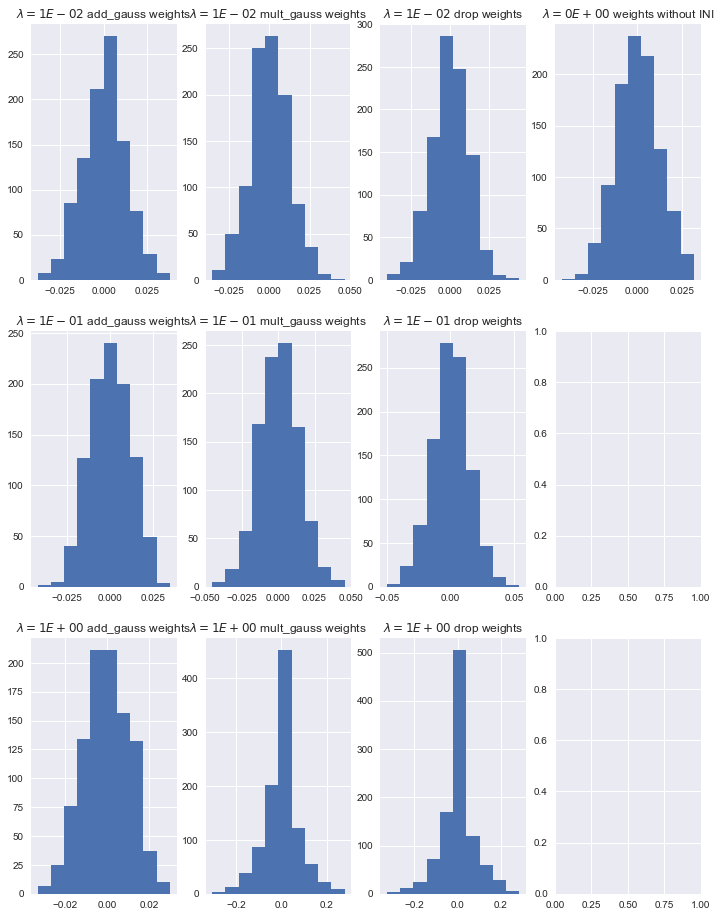

In [49]:
sns.set()
fig, axes = plt.subplots(figsize=(12, 16), ncols=4, nrows=3)

_ = axes[0][3].hist(act1_linear[0].flatten())
axes[0][3].set_title(r'$\lambda = %0.0E$ weights without INI' % 0)

_ = axes[0][0].hist(act1_add[0].flatten())
axes[0][0].set_title(r'$\lambda = %0.0E$ add_gauss weights' % lambdas[0])
_ = axes[0][1].hist(act1_mult[0].flatten())
axes[0][1].set_title(r'$\lambda = %0.0E$ mult_gauss weights' % lambdas[0])
_ = axes[0][2].hist(act1_drop[0].flatten())
axes[0][2].set_title(r'$\lambda = %0.0E$ drop weights' % lambdas[0])
_ = axes[1][0].hist(act1_add[1].flatten())
axes[1][0].set_title(r'$\lambda = %0.0E$ add_gauss weights' % lambdas[1])
_ = axes[1][1].hist(act1_mult[1].flatten())
axes[1][1].set_title(r'$\lambda = %0.0E$ mult_gauss weights' % lambdas[1])
_ = axes[1][2].hist(act1_drop[1].flatten())
axes[1][2].set_title(r'$\lambda = %0.0E$ drop weights' % lambdas[1])
_ = axes[2][0].hist(act1_add[2].flatten())
axes[2][0].set_title(r'$\lambda = %0.0E$ add_gauss weights' % lambdas[2])
_ = axes[2][1].hist(act1_mult[2].flatten())
axes[2][1].set_title(r'$\lambda = %0.0E$ mult_gauss weights' % lambdas[2])
_ = axes[2][2].hist(act1_drop[2].flatten())
axes[2][2].set_title(r'$\lambda = %0.0E$ drop weights' % lambdas[2])
plt.show()

In [59]:
a=np.where(abs(act1_drop[2])<0.05)

In [73]:
hist(a[0].flatten)
plt.show

NameError: name 'hist' is not defined

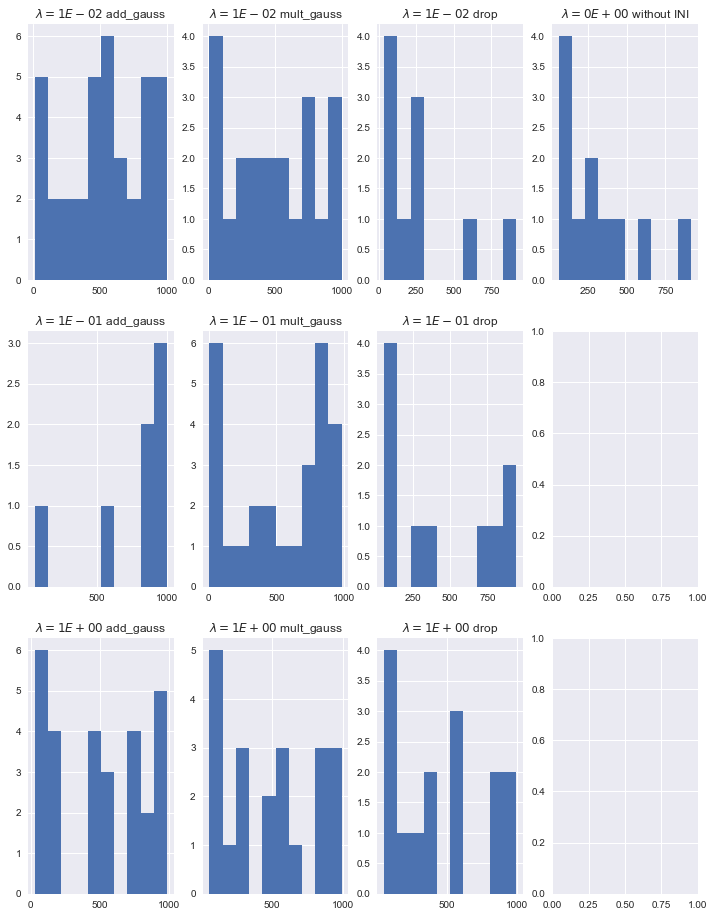

In [89]:
sns.set()
fig, axes = plt.subplots(figsize=(12, 16), ncols=4, nrows=3)

_ = axes[0][3].hist(np.where(abs(act1_linear[0])>0.7 * max(abs(act1_linear[0])))[0])
axes[0][3].set_title(r'$\lambda = %0.0E$ without INI' % 0)

_ = axes[0][0].hist(np.where(abs(act1_add[0])>0.7 * max(abs(act1_add[0])))[0])
axes[0][0].set_title(r'$\lambda = %0.0E$ add_gauss' % lambdas[0])
_ = axes[0][1].hist(np.where(abs(act1_mult[0])>0.6 * max(abs(act1_mult[0])))[0])
axes[0][1].set_title(r'$\lambda = %0.0E$ mult_gauss' % lambdas[0])
_ = axes[0][2].hist(np.where(abs(act1_drop[0])>0.7 * max(abs(act1_drop[0])))[0])
axes[0][2].set_title(r'$\lambda = %0.0E$ drop ' % lambdas[0])
_ = axes[1][0].hist(np.where(abs(act1_add[1])>0.7 * max(abs(act1_add[1])))[0])
axes[1][0].set_title(r'$\lambda = %0.0E$ add_gauss' % lambdas[1])
_ = axes[1][1].hist(np.where(abs(act1_mult[1])>0.7 * max(abs(act1_mult[1])))[0])
axes[1][1].set_title(r'$\lambda = %0.0E$ mult_gauss' % lambdas[1])
_ = axes[1][2].hist(np.where(abs(act1_drop[1])>0.7 * max(abs(act1_drop[1])))[0])
axes[1][2].set_title(r'$\lambda = %0.0E$ drop' % lambdas[1])
_ = axes[2][0].hist(np.where(abs(act1_add[2])>0.7 * max(abs(act1_add[2])))[0])
axes[2][0].set_title(r'$\lambda = %0.0E$ add_gauss' % lambdas[2])
_ = axes[2][1].hist(np.where(abs(act1_mult[2])>0.7 * max(abs(act1_mult[2])))[0])
axes[2][1].set_title(r'$\lambda = %0.0E$ mult_gauss' % lambdas[2])
_ = axes[2][2].hist(np.where(abs(act1_drop[2])>0.7 * max(abs(act1_drop[2])))[0])
axes[2][2].set_title(r'$\lambda = %0.0E$ drop' % lambdas[2])
plt.show()